### Performance evaluation: Snowflake Python Connector vs Snowpark

#### 1. Why Snowpark?

Whether you're a seasoned Snowflake developer or just starting your journey, unleash the capabilities of Snowpark that push down the transformation work where the data reside. Where data doesn’t leave the environment. It going to execute on Snowflake compute resources, and you are going to get scalability and performance you’re expecting.

- The Snowpark library provides an intuitive library for querying and processing data at scale in Snowflake.
- Snowflake currently provides Snowpark libraries for three languages: Java, Python, and Scala.
- Process data in Snowflake without moving data to the system where your application code runs.
- Process at scale as part of elastic and serverless Snowflake engine.

Snowpark DataFrames are more efficient than Pandas DataFrames and can help avoid memory limits common in traditional notebook workflows. It doesn’t matter how large the underlying dataset is; the query is quickly executed on Snowflake’s infrastructure, and only the bite-sized rolled-up final results are returned to client.

#### 2. Benchmark Dataset

TPC-H benchmark dataset is used to measure the performance of different connectors. The dataset includes numerous schemas that only vary in the amount of data.

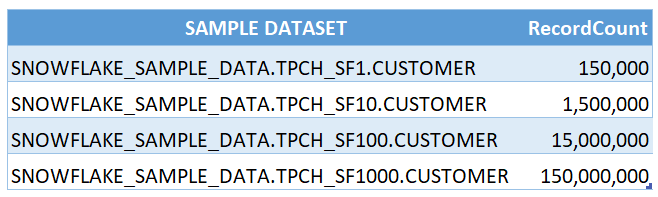

#### 3. Python Connector Performance Evaluation

##### 3.1 Import Snowflake Connector package

In [17]:
import snowflake.connector
import pandas as pd
from datetime import date
import time
import os
import json

#### 3.3 Get user credentials

In [ ]:
with open(r".\secret\creds.json", 'r') as openfile:
        creds = json.load(openfile)

#### 3.4 Connect Snowflake using Python Connector

In [20]:
#creating an instance of the connector object and cursor
ctx = snowflake.connector.connect (
    user=creds["username"],
    password=creds["password"],
    account=creds["account"],
    database=creds["database"],
    schema=creds["schema"],
    warehouse=creds["warehouse"],
    role=creds["role"]     
    )
cs = ctx.cursor()

#### 3.5 Data preparation using Python Connector

In [21]:
print("-------- starting the run -------------")

#clear cached results
cs.execute("ALTER SESSION SET USE_CACHED_RESULT = FALSE")

#set query tag
cs.execute("ALTER SESSION SET QUERY_TAG='Python_Connector'")

#set database
cs.execute("USE DATABASE SNOWFLAKE_SAMPLE_DATA")

#record start time to measure query performance.
start_time = time.time()

#once connection and cursor are created, we execute the query here
try:  
    cs.execute("SELECT C_MKTSEGMENT,C_ACCTBAL FROM TPCH_SF10.CUSTOMER")
    df = cs.fetch_pandas_all()
    
finally:
    print('')
    #cs.close()     
# ctx.close()

#-----Aggregation operation -----
#group by marketsegment
df2 = df.groupby('C_MKTSEGMENT')['C_ACCTBAL'].sum().reset_index()

#get total of accountbalance
acct_bal_total = df2['C_ACCTBAL'].sum()

#create a new column in df2 that shows percentage of market segment
df2['PERCENTAGE'] = round(100*(df2['C_ACCTBAL']/acct_bal_total),2)

#display the result 
print(df2)

#display the query performance time.
print("--- %s seconds ---" % (time.time() - start_time)) #how long it took to run

-------- starting the run -------------

  C_MKTSEGMENT     C_ACCTBAL  PERCENTAGE
0   AUTOMOBILE  1.349031e+09       19.99
1     BUILDING  1.353005e+09       20.05
2    FURNITURE  1.347781e+09       19.97
3    HOUSEHOLD  1.348838e+09       19.99
4    MACHINERY  1.349709e+09       20.00
--- 5.8979363441467285 seconds ---


#### 4. Snowpark Performance Evalution

##### 4.1 Install Snowpark Package - snowflake-snowpark-pythons

##### 4.2 Import Snowpark package

In [37]:
from snowflake.snowpark.session import Session
from snowflake.snowpark.functions import asc, desc, avg, sum, col, lit

from datetime import date
import time
import os
import json

##### 4.3 Connect Snowflake using Snowpark

In [38]:
with open(r".\secret\creds.json", 'r') as openfile:
        creds = json.load(openfile)

connection_parameters = {
        "account": creds["account"],    
        "user" : creds["username"],
        "password" : creds["password"],
        "database" : creds["database"],
        "schema" : creds["schema"],
        "warehouse" : creds["warehouse"],
        "role" : creds["role"]        
    }
    
## Create a Snowpark session
snpark_conn = Session.builder.configs(connection_parameters).getOrCreate()


##### 4.4 Data preparation using Snowpark

In [9]:
#clear cached results
snpark_conn.sql(f"ALTER SESSION SET USE_CACHED_RESULT = FALSE").collect()

#set query tag
snpark_conn.sql(f"ALTER SESSION SET QUERY_TAG='Snowpark-Connector'").collect()

#set database
snpark_conn.sql(f"USE DATABASE SNOWFLAKE_SAMPLE_DATA").collect()

#set warehouse
snpark_conn.sql(f"USE WAREHOUSE TEST_WH_S").collect()

#to measure query performance.
start_time = time.time()

# run the query
df = snpark_conn.sql("SELECT C_ACCTBAL, C_MKTSEGMENT FROM TPCH_SF100.CUSTOMER")
#df.show(5)

#note the the group_by has a different spelling
df2 = df.group_by("C_MKTSEGMENT").agg(sum("C_ACCTBAL").alias("SUBTOTAL"))

#get total of accountbalance
acct_bal_total = df2.agg(sum("SUBTOTAL").alias("SUBTOTAL"))

# store total balance in a variable
for i in acct_bal_total.toLocalIterator():
        total_sum=i["SUBTOTAL"]

#create a new column in df2 that shows percentage of market segment
df2 = df2.with_column("PERCENTAGE",(df2["SUBTOTAL"]*100)/total_sum)
df2 = df2.sort(col("PERCENTAGE").desc())
df2.show()

print("-----------")

print("--- %s seconds ---" % (time.time() - start_time))

--------------------------------------------------
|"C_MKTSEGMENT"  |"SUBTOTAL"      |"PERCENTAGE"  |
--------------------------------------------------
|AUTOMOBILE      |13505921991.12  |20.01521408   |
|FURNITURE       |13502677441.53  |20.01040579   |
|HOUSEHOLD       |13498455855.93  |20.00414958   |
|BUILDING        |13495512103.99  |19.99978706   |
|MACHINERY       |13475711568.07  |19.97044349   |
--------------------------------------------------

-----------
--- 1.8516836166381836 seconds ---


### 5. Performace Evaluation

Python Connector vs. Snowark performance benchmark on TPC-H datasets.

Sections 3.5 and 4.4 only the tables with 1.5 MM data is shown but the chart has time benchmarks for all tables mentioned in the benchmark dataset

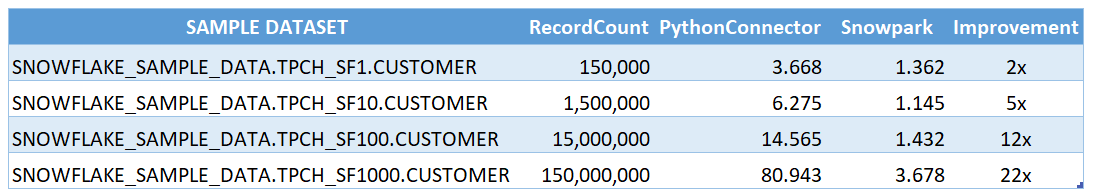

##### 5.1 Plot runtime for first two dataset

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

X = ['TPCH_150k','TPCH_1.5MM']
PyConn = [3.668,6.275]
SnPark = [1.362,1.145]
  
X_axis = np.arange(len(X))
  
plt.bar(X_axis - 0.2, PyConn, 0.4, label = 'PyConn')
plt.bar(X_axis + 0.2, SnPark, 0.4, label = 'SnPark')
  
plt.xticks(X_axis, X)
plt.xlabel("Run Rate")
plt.ylabel("Run Time in Seconds")
plt.title("Python Connecter vs. Snowpark")
plt.legend() 
plt.show()

##### 5.2 Plot runtime for all datasets

For large data set the run time different increses by average 70x

In [ ]:
X = ['TPCH_150k','TPCH_1.5MM','TPCH_15MM','TPCH_150MM']
PyConn = [3.668,6.275,17.348,80.943]
SnPark = [1.362,1.145,1.432,3.678]

X_axis = np.arange(len(X))
  
plt.bar(X_axis - 0.2, PyConn, 0.4, label = 'PyConn')
plt.bar(X_axis + 0.2, SnPark, 0.4, label = 'SnPark')
  
plt.xticks(X_axis, X)
plt.xlabel("Run Rate")
plt.ylabel("Run Time in Seconds")
plt.title("Python Connecter vs. Snowpark")
plt.legend() 
plt.show()

#### Snowflake Connector: Read

In [12]:
from snowflake.connector.converter_null import SnowflakeNoConverterToPython
con = snowflake.connector.connect(
    ...
    converter_class=SnowflakeNoConverterToPython
)

# display the query performance time.
pyConRead = time.time() - start_time
print(f"This table took {pyConRead} sec to read in")

#### Snowflake Connector: Write

In [ ]:
print("-------- starting the run -------------")

#record start time to measure query performance.
start_time = time.time()

#display the query performance time.
pyConWrite = time.time() - start_time
print(f"This table took {pyConWrite} sec to write out")

#### Write Snowflake DataFrame to Table

In [34]:
import pandas
from snowflake.connector.pandas_tools import write_pandas
cs = ctx.cursor()
cs.execute("SELECT C_MKTSEGMENT,C_ACCTBAL FROM SNOWFLAKE_SAMPLE_DATA.TPCH_SF10.CUSTOMER")
p_df = cs.fetch_pandas_all()
p_df.head()

,C_MKTSEGMENT,C_ACCTBAL
0,BUILDING,9417.98
1,MACHINERY,7084.13
2,BUILDING,7979.53
3,BUILDING,8950.12
4,MACHINERY,8715.76


In [35]:
# Create a DataFrame containing data about customers
#p_df = pandas.DataFrame([('Mark', 10), ('Luke', 20)], columns=['name', 'balance'])

# Write the data from the DataFrame to the table named "customers".
success, nchunks, nrows, _ = write_pandas(conn=ctx, 
                                          df=p_df,
                                          database='TEST_XXXXXX',
                                          schema='TEST_XXXXXXXXXX',
                                          table_name='XXXXXXXXXX',
                                          auto_create_table=True,
                                          overwrite=True
                                          )

#https://docs.snowflake.com/en/developer-guide/python-connector/python-connector-api#write_pandas
#https://ponder.io/how-to-use-snowflake-write_pandas/

#### Write Snowpark DataFrame to Table

In [ ]:
# run the query
sf_df = snpark_conn.sql("SELECT C_ACCTBAL, C_MKTSEGMENT FROM SNOWFLAKE_SAMPLE_DATA.TPCH_SF10.CUSTOMER")
sf_df.show(10)

In [42]:
#Write the Snowflake data frame to a table in Snowflake    
sf_df.write.save_as_table("XXXXXXXXXX.XXXXXXXXXXXX", mode="append")